In [3]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('../..')
sys.path.append('../../lib/src/')
sys.path.append('../../TopographicVAE-master')
import torch
from torch import nn
import torch.nn.functional as F
import os
from itertools import islice
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config, LVAE_IAF
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, Encoder_ColorMNIST,Decoder_ColorMNIST
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(grid, color=False):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()


%reload_ext autoreload
%autoreload 2

!nvidia-smi

Thu Aug  1 20:11:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   42C    P8             10W /   70W |     953MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([700, 10, 1, 64, 64])


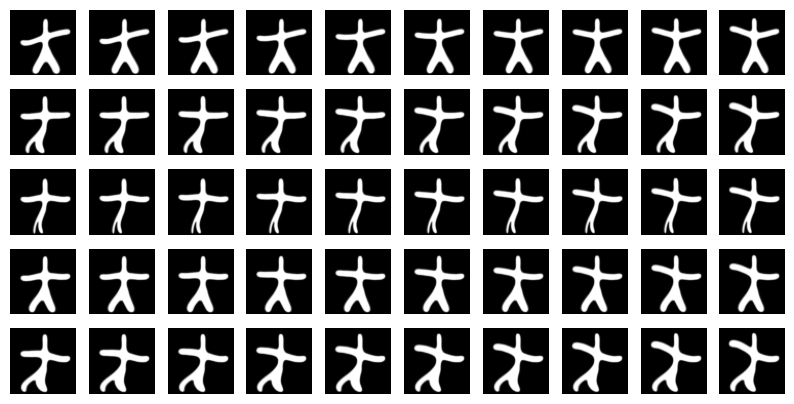

In [4]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load('starmen_data.pt')[:700].unsqueeze(2)
eval_data = torch.load('starmen_data.pt')[700:900].unsqueeze(2)
test_data = torch.load('starmen_data.pt')[900:].unsqueeze(2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

plot_sequence(train_data[:5], color=False)

In [5]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)


PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-08-01_16-38-44/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_2/checkpoints/epoch=99-step=1100.ckpt'


# Avec prior 'allongée' mais pas décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-27_11-46-10/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_7/checkpoints/epoch=49-step=1600.ckpt'


# Prior décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-07-01_16-05-18/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_15/checkpoints/epoch=49-step=1600.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids
Finding temperature
Best temperature found:  2.5016002655029297
Building metric
Increasing T by  5
Adding std normal to centroids and var
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [6]:
model_config = LVAE_IAF_Config(
    input_dim=(1, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    #########################
    warmup=0,
    #########################
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=200,
        learning_rate=5*1e-4,
        batch_size=32,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cpu'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                 precomputed_zT_samples=None, verbose = True, temp = temperature)

#model = LVAE_IAF(model_config, encoder, decoder).cuda()

Diffusion time steps  [999 888 777 666 555 444 333 222 111   0]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


In [7]:
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_14-46-51/final_model/model.pt')['model_state_dict'])
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-08-01_19-43-09/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

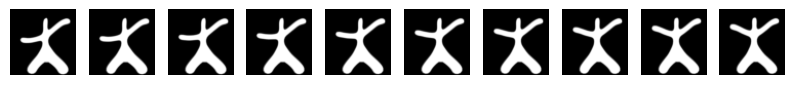

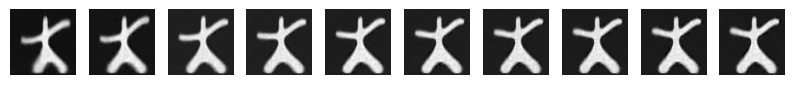

Reconstruction loss: 24.31783103942871


In [13]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm = lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 5)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [15]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 10, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([700, 10, 12])


Running Kmedoids
Finding temperature
Best temperature found:  74.83901977539062
Building metric
Increasing T by  1
Sampling 10 points on the 5th/rd manifold...
Propagating in the past...
Propagating in the future...
Decoding...


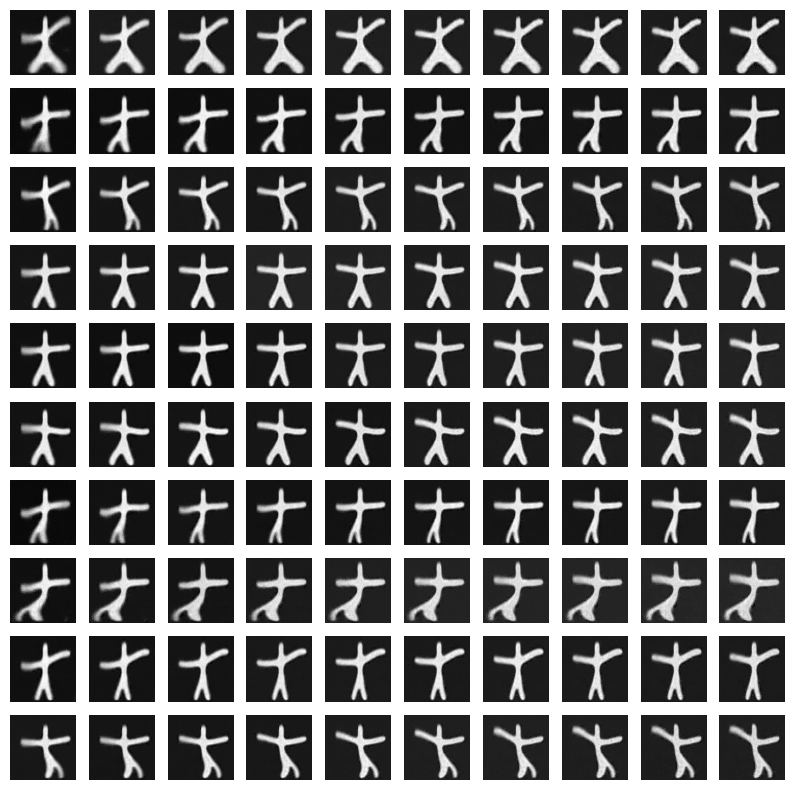

In [19]:
lldm.temperature = 1
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=10, vi_index =5 , T_multiplier = 1, freeze=False)
plot_sequence(recon_x)

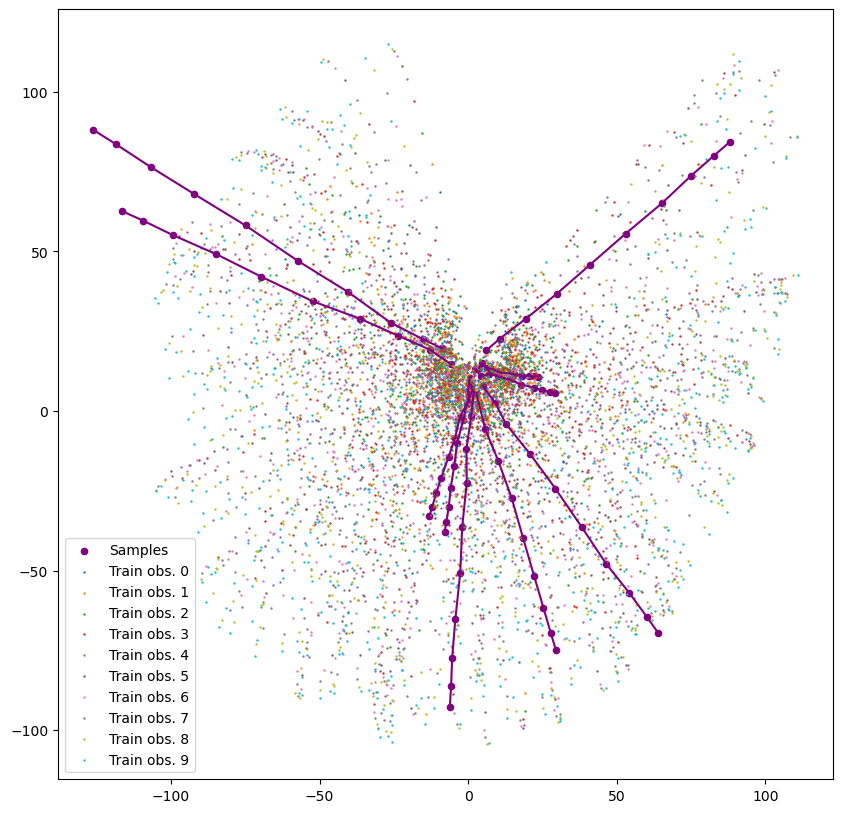

In [20]:
num_obs =  NUM_OBS =  train_data.shape[1] 
pca = PCA(n_components=2)
n_samples = z_seq.shape[0]
train_embeddings_pca = pca.fit_transform(train_embeddings.reshape(-1, latent_dim).cpu().detach().numpy()).reshape(-1, num_obs, 2)

displayed_indexes = range(num_obs)  #range(num_obs)

all_sequences = z_seq
all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
all_sequences_pca = all_sequences_pca.reshape(n_samples, NUM_OBS, 2)
plt.figure(figsize=(10, 10))
plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Train obs. {i}')

for i in range(n_samples):
    plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


plt.legend()
plt.show()


In [ ]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =2 , T_multiplier = 1)
print(recon_x.shape)
print(test_data.shape)

In [19]:
import torch
from torcheval.metrics import FrechetInceptionDistance

def compute_fid_with_torcheval(real_images, generated_images, batch_size=256, device='cuda'):
    # Initialize FID metric
    fid_metric = FrechetInceptionDistance().to(device)
    
    def process_in_batches(images, real):
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            fid_metric.update(batch, is_real=real)
            # Clear the batch from memory
            del batch
            torch.cuda.empty_cache()
    
    # Process real images in batches
    process_in_batches(real_images, real=True)
    
    # Process generated images in batches
    process_in_batches(generated_images, real=False)
    
    # Compute the FID score
    fid_score = fid_metric.compute()
    return fid_score

# Example usage:
real_images = test_data.reshape(-1, 3, 64, 64).clamp(0, 1)
generated_images = recon_x.reshape(-1, 3, 64, 64).clamp(0, 1)

fid_score = compute_fid_with_torcheval(real_images, generated_images)
print('FID score:', fid_score)


FID score: tensor(36.7052, device='cuda:0')


In [16]:
test_nll = []
batch_size=100
n_runs=5
n_samples = batch_size
lldm.device = 'cuda'
for _ in range(n_runs):
    test_nll.append(lldm.get_nll(data=test_data, vi_index = 2, n_samples=n_samples, batch_size=batch_size))

test_nll

  2%|▏         | 2/100 [00:00<00:20,  4.67it/s]

Current nll at 0: -3773.182580916717


  2%|▏         | 2/100 [00:00<00:16,  5.91it/s]

Current nll at 0: -3773.208233498733


  2%|▏         | 2/100 [00:00<00:16,  5.91it/s]

Current nll at 0: -3772.7014042697733


  2%|▏         | 2/100 [00:00<00:16,  5.90it/s]

Current nll at 0: -3773.042783043781


  2%|▏         | 2/100 [00:00<00:16,  5.91it/s]

Current nll at 0: -3773.1805594417237


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


[-3778.5877809249487,
 -3778.680046226085,
 -3778.6440958545845,
 -3778.6813580691687,
 -3778.664634556757]